In [42]:
# Setting up environment

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib

from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv

load_dotenv()
mpl.rcParams['figure.figsize'] = (12, 10)

In [43]:
# drop colomn
def dropColomn(df, col):
    try:
        df = df.drop(col,1)
    except:
        print('colomn {0} not found'.format(col))
    return df

# split dataframe to feature target numpy array
def split_feature_label(df):
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

In [44]:
# processing testing dataset

# import dataset
test_df = pd.read_csv(os.getcwd()+'/datasets/testing.csv')
# drop colomn id
test_df = dropColomn(test_df, 'id')

# split features and labels
x_test, y_test = split_feature_label(test_df)

print('shape of testing feature: {0}'.format(x_test.shape))
print('shape of testing labels: {0}'.format(y_test.shape))

shape of testing feature: (542, 14)
shape of testing labels: (542,)


In [45]:
# processing training dataset
# import dataset
dataset = pd.read_csv(os.getcwd()+'/datasets/sampled_dataset.csv')

# drop colomm id
dataset = dropColomn(dataset, 'id')

# split features and labels
x,y = split_feature_label(dataset)

print('shape of training feature: {0}'.format(x.shape))
print('shape of training labels: {0}'.format(y.shape))


shape of training feature: (3676, 14)
shape of training labels: (3676,)


In [46]:
# split to training and validating dataset
from sklearn.model_selection import train_test_split

TESTSIZE = float(os.getenv('VALRATE'))
TESTRANDOMSTATE = int(os.getenv('VALRANDOMSTATE'))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = TESTSIZE, random_state = TESTRANDOMSTATE)

print('shape of training feature: {0}'.format(x_train.shape))
print('shape of training labels: {0}'.format(y_train.shape))

print('shape of validation feature: {0}'.format(x_val.shape))
print('shape of validation labels: {0}'.format(y_val.shape))


shape of training feature: (2757, 14)
shape of training labels: (2757,)
shape of validation feature: (919, 14)
shape of validation labels: (919,)


In [47]:
# Scaling data using standar scaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

# save scaler variable into file
scaler_filename = os.getenv("SCALER_FILENAME")
joblib.dump(sc, scaler_filename) 


['model/scaler.save']

In [48]:
# building model

BATCH_SIZE = int(os.getenv('BATCHSIZE'))
EPOCHS = int(os.getenv('EPOCH'))

METRICS = [
    # keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    # keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # keras.metrics.AUC(name='auc'),
    # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS ):
    model = keras.Sequential([
        keras.layers.Dense(
            32, activation='relu',
            input_shape=(x_train.shape[-1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(
            24, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(
            16, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=32,
    mode='max',
    restore_best_weights=True)

In [49]:
model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                480       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_10 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [50]:
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=early_stopping)

Epoch 1/1024
44/44 [==============================] - 1s 8ms/step - loss: 0.7243 - accuracy: 0.5161 - precision: 0.5116 - recall: 0.5632 - val_loss: 0.6587 - val_accuracy: 0.6344 - val_precision: 0.6762 - val_recall: 0.5499
Epoch 2/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5615 - precision: 0.5688 - recall: 0.4828 - val_loss: 0.6566 - val_accuracy: 0.6409 - val_precision: 0.6776 - val_recall: 0.5711
Epoch 3/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5829 - precision: 0.5916 - recall: 0.5164 - val_loss: 0.6434 - val_accuracy: 0.6627 - val_precision: 0.6746 - val_recall: 0.6603
Epoch 4/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5811 - precision: 0.5841 - recall: 0.5427 - val_loss: 0.6379 - val_accuracy: 0.6768 - val_precision: 0.6790 - val_recall: 0.7006
Epoch 5/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.6036 - pr

In [59]:
model.save('model/ann_model/')

INFO:tensorflow:Assets written to: model/ann_model/assets


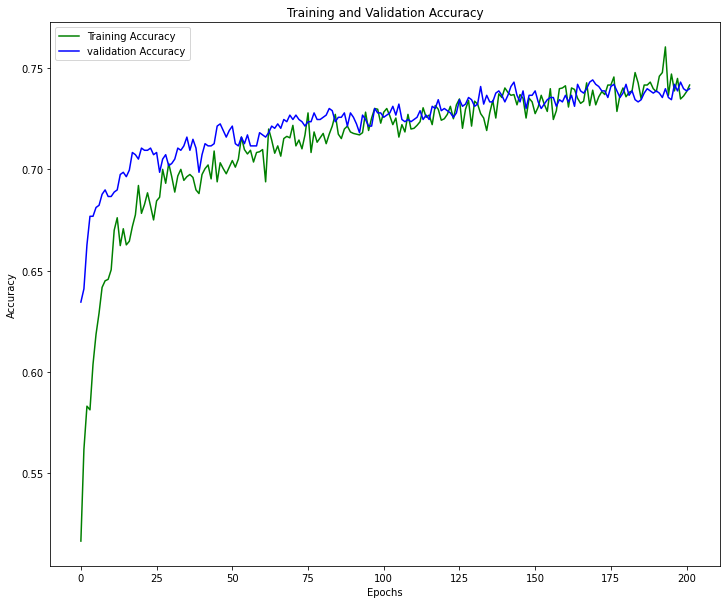

In [52]:
loss_train = zero_bias_history.history['accuracy']
loss_val = zero_bias_history.history['val_accuracy']
epochs = range(len(zero_bias_history.history['accuracy']))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

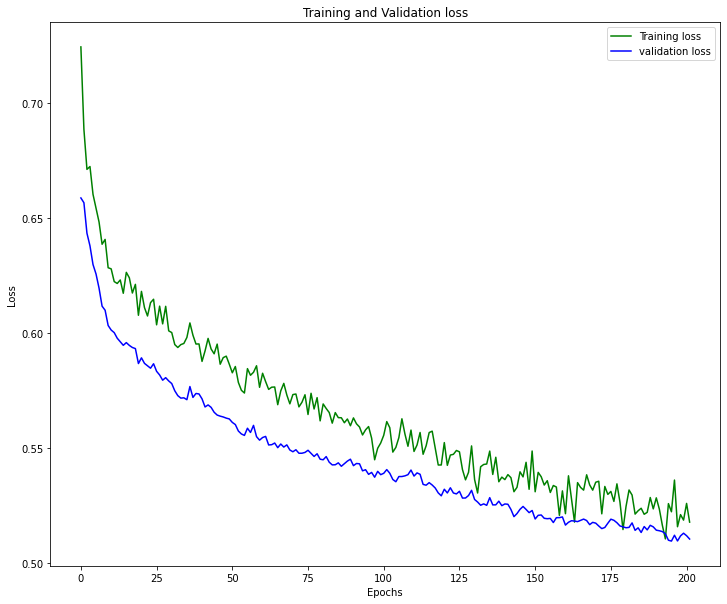

In [53]:
loss_train = zero_bias_history.history['loss']
loss_val = zero_bias_history.history['val_loss']
epochs = range(len(zero_bias_history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): {0}, with percentage : {1}'.format(cm[0][0], cm[0][0]/len(labels)))
    print('Legitimate Transactions Incorrectly Detected (False Positives): {0}, with percentage : {1}'.format(cm[0][1], cm[0][1]/len(labels)))
    print('Fraudulent Transactions Missed (False Negatives): {0}, with percentage : {1}'.format(cm[1][0], cm[1][0]/len(labels)))
    print('Fraudulent Transactions Detected (True Positives): {0}, with percentage : {1}'.format(cm[1][1], cm[1][1]/len(labels)))
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

    print('Accuracy : ', accuracy_score(labels, predictions > p))

[[0.73524451 0.        ]
 [0.49445307 0.        ]
 [0.31162742 0.        ]
 ...
 [0.53677338 0.        ]
 [0.32919508 1.        ]
 [0.87288988 1.        ]]
Legitimate Transactions Detected (True Negatives): 373, with percentage : 0.6881918819188192
Legitimate Transactions Incorrectly Detected (False Positives): 87, with percentage : 0.16051660516605165
Fraudulent Transactions Missed (False Negatives): 46, with percentage : 0.08487084870848709
Fraudulent Transactions Detected (True Positives): 36, with percentage : 0.06642066420664207
Total Fraudulent Transactions:  82
Accuracy :  0.7546125461254612


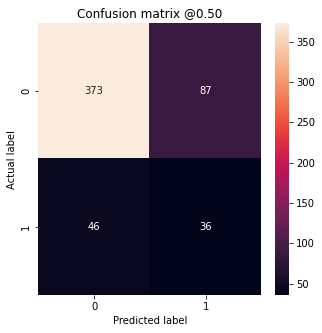

In [58]:
# predicting test data
y_pred = model.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
plot_cm(y_test, y_pred)

[[0.33180875 1.        ]
 [0.43099615 0.        ]
 [0.88750935 1.        ]
 ...
 [0.82685947 1.        ]
 [0.34641114 1.        ]
 [0.71414959 1.        ]]
Legitimate Transactions Detected (True Negatives): 368, with percentage : 0.40043525571273125
Legitimate Transactions Incorrectly Detected (False Positives): 80, with percentage : 0.08705114254624592
Fraudulent Transactions Missed (False Negatives): 155, with percentage : 0.16866158868335146
Fraudulent Transactions Detected (True Positives): 316, with percentage : 0.3438520130576714
Total Fraudulent Transactions:  471
Accuracy :  0.7442872687704026


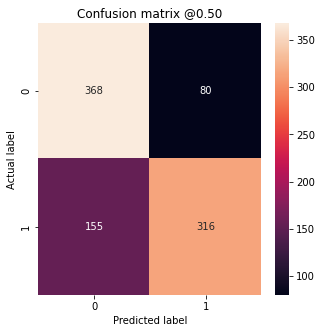

In [56]:
# conf matrix on validation data

y_pred = model.predict(x_val)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_val.reshape(len(y_val),1)),1))

plot_cm(y_val, y_pred)